# Calculate the inter-rater reliability scores for the selected datasets

In [1]:
import statistics
import sys

sys.path.append("../")
import copy

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import src.data.prepare_data as prepdata
from nltk.metrics import binary_distance, interval_distance
from nltk.metrics.agreement import AnnotationTask
from src.data.data_loader import (
    EastAsianPrejudiceDataset,
    MisogynyDataset,
    RedditDataset,
    WikipediaDataset,
)
from tqdm.notebook import tqdm

# Load datasets

In [2]:
(
    cm_ea,
    gl_ea,
    aw_ea,
    al_ea,
) = prepdata.get_annotator_and_gold_labels_EastAsian()

(
    cm_re,
    gl_re,
    aw_re,
    al_re,
) = prepdata.get_annotator_and_gold_labels_Reddit()

(
    cm_mi,
    gl_mi,
    aw_mi,
    al_mi,
) = prepdata.get_annotator_and_gold_labels_Misogyny()

(
    cm_wiki,
    gl_wiki,
    aw_wiki,
    al_wiki,
) = prepdata.get_annotator_and_gold_labels_Wikipedia()

Loaded data
----------------------------------
115864 comments
4053 annotators
2 classes: [0.0, 1.0]
----------------------------------
Running majority voting
Completed majority_voting in 0:00:01.322031 seconds



## Define function for calculating Krippendorff's alpha

In [3]:
def getKrippendorffsAlphaIndividuals(annotator_labels_long, gold_labels):
    annotator_ids = list(set(annotator_labels_long["annotator"].to_list()))
    annotator_ids_2 = []
    annotators_scores = []

    triples_gold = []
    for index, row in gold_labels.iterrows():
        triple = ("gold", row["id"], row["label"])
        triples_gold.append(triple)

    for annotator in tqdm(annotator_ids):
        try:
            annotation_triples = copy.deepcopy(triples_gold)
            for index, row in annotator_labels_long[
                annotator_labels_long["annotator"] == annotator
            ].iterrows():
                triple = (annotator, row["id"], row["label"])
                annotation_triples.append(triple)
            t = AnnotationTask(annotation_triples, distance=binary_distance)
            annotators_scores.append(t.alpha())
            annotator_ids_2.append(annotator)
        except:
            pass
    return annotator_ids_2, annotators_scores


def getKrippendorffsAlphaOverall(annotator_labels_long):
    annotation_triples = []
    for index, row in annotator_labels_long.iterrows():
        triple = (row["annotator"], row["id"], row["label"])
        annotation_triples.append(triple)
    t = AnnotationTask(annotation_triples, distance=binary_distance)
    return t.alpha()

## Calculate scores
This can take a while because the Wikipedia dataset has many annotators

In [4]:
ids_ea, scores_ea = getKrippendorffsAlphaIndividuals(al_ea, gl_ea)
ids_re, scores_re = getKrippendorffsAlphaIndividuals(al_re, gl_re)
ids_mi, scores_mi = getKrippendorffsAlphaIndividuals(al_mi, gl_mi)
ids_wiki, scores_wiki = getKrippendorffsAlphaIndividuals(al_wiki, gl_wiki)

ka_ea = getKrippendorffsAlphaOverall(al_ea)
ka_re = getKrippendorffsAlphaOverall(al_re)
ka_mi = getKrippendorffsAlphaOverall(al_mi)
ka_wiki = getKrippendorffsAlphaOverall(al_wiki)



## Merge scores in one dataframe

In [5]:
dataset_names = ["Vidgen","Guest", "Kurrek", "Wulczyn"]
list_for_df = []
for i, scores in zip(dataset_names, [scores_ea, scores_mi,scores_re, scores_wiki]):
    for score in scores:
        list_for_df.append([i, score])
df_ira_scores = pd.DataFrame(list_for_df, columns=["Dataset", "Krippendorf's alpha"])


list_for_df = []
for i, score in zip(dataset_names, [ka_ea, ka_mi,ka_re, ka_wiki]):
    list_for_df.append([i, score])
df_overall_scores = pd.DataFrame(
    list_for_df, columns=["Dataset", "Krippendorf's alpha"]
)

## Plot the scores

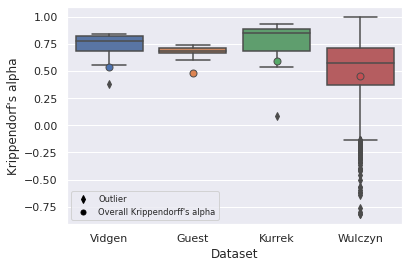

In [6]:
fig = plt.figure(figsize=(6, 4))
ax = sns.boxplot(
    x="Dataset",
    y="Krippendorf's alpha",
    data=df_ira_scores,
)
ax2 = sns.stripplot(
    x="Dataset",
    y="Krippendorf's alpha",
    data=df_overall_scores,
    jitter=0,
    linewidth=1,
    marker="o",
    size=7,
)


outlier = mlines.Line2D(
    [], [], color="black", marker="d", linestyle="None", markersize=5, label="_"
)
overall = mlines.Line2D(
    [], [], color="black", marker="o", linestyle="None", markersize=5, label="_"
)
plt.legend(
    handles=[outlier, overall],
    loc="lower left",
    labels=["Outlier", "Overall Krippendorff's alpha"],
    fontsize="x-small",
)

plt.show()
fig.savefig('../outputs/krippendorffs_alpha.pdf', dpi=300, bbox_inches='tight')